### **Run Code on Colab**

In [1]:
!pip install -q langgraph python-dotenv

In [2]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time
from dotenv import load_dotenv

_ = load_dotenv()

In [3]:
# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [4]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(30)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"done": True}

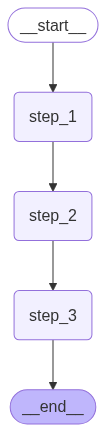

In [5]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
graph

In [6]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
❌ Kernel manually interrupted (crash simulated).


In [7]:
graph.get_state({"configurable": {"thread_id": 'thread-1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ef9f-e557-6215-8001-770653d0eba7'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-11T10:28:01.349879+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ef9f-e555-6483-8000-c62d09970d17'}}, tasks=(PregelTask(id='cc376d34-ce88-383f-24b6-c7d8c9a1165e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [8]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ef9f-e557-6215-8001-770653d0eba7'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-11T10:28:01.349879+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ef9f-e555-6483-8000-c62d09970d17'}}, tasks=(PregelTask(id='cc376d34-ce88-383f-24b6-c7d8c9a1165e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ef9f-e555-6483-8000-c62d09970d17'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-11T10:28:01.349120+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'ch

In [9]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)


🔁 Re-running the graph to demonstrate fault tolerance...
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
✅ Step 3 executed

✅ Final State: {'input': 'start', 'step1': 'done', 'step2': 'done'}


In [10]:
graph.get_state({"configurable": {"thread_id": 'thread-1'}})

StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08efa1-7e6d-6ef7-8003-cdd80e4e9242'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-09-11T10:28:44.245971+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08efa1-7e6b-6f13-8002-affc9cfb956a'}}, tasks=(), interrupts=())

In [11]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=(), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08efa1-7e6d-6ef7-8003-cdd80e4e9242'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-09-11T10:28:44.245971+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08efa1-7e6b-6f13-8002-affc9cfb956a'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08efa1-7e6b-6f13-8002-affc9cfb956a'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-11T10:28:44.245144+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f08ef9f-e557-6215-8001-770653d0eba7'}}, tasks=(PregelTask(id='a35e14d8-5534-4e23-d7ab-73d367032db